# Notebook to develop the model for the project
https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

https://towardsdatascience.com/transformers-explained-visually-not-just-how-but-why-they-work-so-well-d840bd61a9d3

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

https://arxiv.org/pdf/2004.13621.pdf

https://github.com/tahmid0007/VisionTransformer

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os

#for all the plots to be inline
%matplotlib inline 


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.values[index][0]
        labels = np.array([1, 1, 1, 1, 1, 1, 1, 1])
        labels = np.array([0., 0., 0., 0., 0., 0., 0., 0.])
        labels = torch.from_numpy(labels)
        for x in range(0, 8):
            labels[x] = self.df.values[index][x+1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, labels


In [3]:
# Select device to train on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = 'cpu'

cuda:0


In [4]:
'''Data Set manipulation'''
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

root = "home/erud1t3/Desktop"
trainDataset = CustomDataset("../data/plotData/labels/trainPlots.csv",
                               "../data/plotData/trainPlots", transform)

testDataset = CustomDataset("../data/plotData/labels/testPlots.csv",
                               "../data/plotData/testPlots", transform)


In [5]:
train_set = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=128)
test_set = torch.utils.data.DataLoader(testDataset, shuffle=False, batch_size=128)

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Train Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([-4.2100, -9.6700,  6.7200, -2.5800,  3.3700, -8.7300,  0.1000,  2.4500],
       dtype=torch.float64)

torch.Size([1, 96, 96]) torch.Size([8])


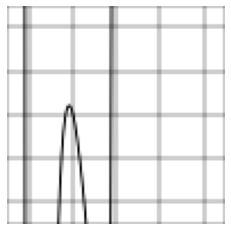

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Test Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([-5.2100,  8.7300,  4.5700,  4.6000,  2.1200, -8.6400, -9.6400, -5.7500],
       dtype=torch.float64)

torch.Size([1, 96, 96]) torch.Size([8])


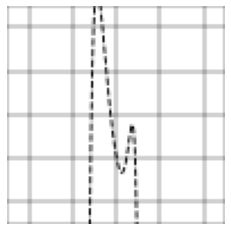

In [6]:
#one way to see batch size
train_batch = next(iter(train_set))
img, lbls = train_batch
print(img.shape, lbls.shape)

#display the first image in train_set
#note: image changes each time run because shuffle is set to true
for images, labels in train_set:
    image, label = images[0], labels[0]
    print(f"Train Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break
    
#test batch size
test_batch = next(iter(test_set))
img, lbls = test_batch
print(img.shape, lbls.shape)

#display the first image in test_set
for images, labels in test_set:
    image, label = images[0], labels[0]
    print(f"Test Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
        self.n_input = 1568 # the output of maxpool 96*96 
        self.image_dim = 96*96*self.n_channel
        
        self.self_attn = nn.MultiHeadAttention(
            embed_dim=self.image_dim, num_heads=8)

        # cannot build architecture at random. There needs to be
        # a way to be reason for the architecture
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3), # convolution2dLayer(3,8,'Padding','same')
            nn.BatchNorm2d(8),   # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
            nn.Conv2d(8, 16, 3), # convolution2dLayer(3,16,'Padding','same')
            nn.BatchNorm2d(16), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
            nn.Conv2d(16, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.BatchNorm2d(32), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.BatchNorm2d(32), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2) # Max pooling layer
        )

        #TODO:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

        self.fc_layers = nn.Sequential(
            nn.Linear(self.n_input,  4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, self.n_output),
            nn.LeakyReLU()
        )


    def forward(self, x):
        #feedword pass through our network
        x = self.cnn_layers(x)
        x = x.view(x.shape[0], -1) #flatten the input tensor
        x = self.fc_layers(x)
        return x


    @staticmethod
    def load_checkpoint(new_model, filepath):
        checkpoint = torch.load(filepath)
        new_model.load_state_dict(checkpoint['state_dict'])
        return new_model
    
    def save(self, dirpath):
        self.checkpoint = {
            'state_dict': model.state_dict()
        }
        torch.save(self.checkpoint, f'{dirpath}/model_checkpoint.pth')
    


In [8]:

# Measure of accuracy
class Measure_Acc(nn.Module):
    '''
    Creating a measure of accuracy for our network
    based on the RMSE 
    '''
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predicted, target):
        rmse = torch.sqrt(self.mse(predicted, target))
        rmse_norm = rmse /  20. # normalization 20 = 10 - (-10)
        # print('rmse normal =', rmse_norm)
        accuracy = 100 * (1 - rmse_norm)
        return accuracy

rmse_accuracy = Measure_Acc()

In [9]:

def validation(model, testloader, criterion):
    '''
    Defining the validation and train
    functions for training phase
    '''

    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
        # images = images.view(images.shape[0], -1)
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        # print(f'output={output.shape}')
        # print(f'label={labels.shape}')
        test_loss += criterion(output, labels)
        accuracy += rmse_accuracy(output, labels)

    # get averages
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(testloader)

    # check if loss is on gpu
    if (test_loss.is_cuda):
        test_loss = test_loss.cpu()

    return test_loss, accuracy
    

In [ ]:

def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    
    test_losses = []
    train_losses = []
    steps = 0
    running_loss = 0

    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        
        num_examples = 0
        for images, labels in trainloader:
            steps += 1

            if num_examples > 1000: 
                break
            else: 
                num_examples += 1
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # Flatten images into a 784 long vector
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model.forward(images)
            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()

                test_loss = 0 # Test loss

                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, _ = validation(model, testloader, criterion)
                    
                
                r = running_loss/print_every
                t = test_loss
                train_losses.append(r)
                test_losses.append(t)

                if steps % print_every == 0:
                    print(f"Epoch: {steps}/{e+1}/{epochs}.. ",
                            f"Training Loss: {r:.3f}.. ",
                            f"Test Loss: {t:.3f}.. ")
                        #   "Test Accuracy: {:.3f}".format(accuracy/len(testloader))
                            # )
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

    plt.ylim([0, 50])          
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    


In [11]:
def test_model(model, test_set):
    test_batch = next(iter(test_set))
    img, lbls = test_batch
    img, lbls = img.to(device), lbls.to(device)
    # print(img.shape, lbls.shape)

    output = model.forward(img)
    #print(output)
    #print(lbls)

    x = np.linspace(-5, 5, 1000)

    output0_coeff = output[0]
    output0_coeff = output0_coeff.detach().cpu().numpy()
    lbls0_coeff = lbls[0]
    lbls0_coeff = lbls0_coeff.detach().cpu().numpy()
    fig, ax = plt.subplots()

    #display output[0] curve
    print(f'Output tensor: {output0_coeff}')
    print('Output curve: ')
    ax.plot(x, ((output0_coeff[7]*x**8)+(output0_coeff[6]*x**7)+(output0_coeff[5]*x**6)
                +(output0_coeff[4]*x**5)+(output0_coeff[3]*x**4)+(output0_coeff[2]*x**3)
                +(output0_coeff[1]*x**2)+(output0_coeff[0]*x**1)),
                color='#000000')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(left = False, labelleft = False,
                    bottom =  False, labelbottom = False)
    ax.grid(color='#000001')

    plt.show()

    #display actual curve
    print(f'Actual label tensor: {lbls0_coeff}')
    print('Actual curve: ')
    fig, ax = plt.subplots()

    ax.plot(x, ((lbls0_coeff[7]*x**8)+(lbls0_coeff[6]*x**7)+(lbls0_coeff[5]*x**6)
                +(lbls0_coeff[4]*x**5)+(lbls0_coeff[3]*x**4)+(lbls0_coeff[2]*x**3)
                +(lbls0_coeff[1]*x**2)+(lbls0_coeff[0]*x**1)),
                color='#000000')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(left = False, labelleft = False,
                    bottom =  False, labelbottom = False)
    ax.grid(color='#000001')

    plt.show()
    

In [12]:
model = Network()
model.to(device)
print(model)

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [17]:
train(
    model=model, 
    trainloader=train_set, 
    testloader=test_set, 
    criterion=nn.MSELoss(), 
    optimizer=optim.Adam(
        model.parameters(), 
        lr=0.001,
        weight_decay=0.0001), 
    epochs=100, 
    print_every=100
)


KeyboardInterrupt: 

Output tensor: [-5.0008836  3.8648174 -1.0877517  1.5648985  3.9591541 -3.7087882
 -3.5374236 -5.4500713]
Output curve: 


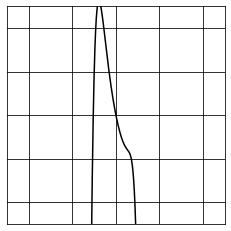

Actual label tensor: [-5.21  8.73  4.57  4.6   2.12 -8.64 -9.64 -5.75]
Actual curve: 


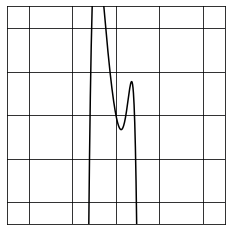

In [18]:
test_model(model, test_set)

In [19]:
# Save the network
model.save('../models')

In [21]:
# laod network from save
net_path = "../models/model_checkpoint.pth"
new_model = Network()
Network.load_checkpoint(new_model, net_path)

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

Output tensor: [-5.0008836  3.8648174 -1.0877517  1.5648985  3.9591541 -3.7087882
 -3.5374236 -5.4500713]
Output curve: 


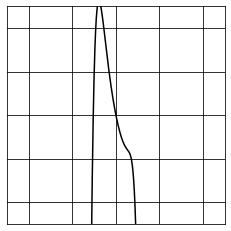

Actual label tensor: [-5.21  8.73  4.57  4.6   2.12 -8.64 -9.64 -5.75]
Actual curve: 


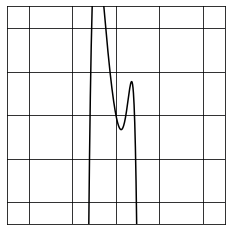

In [23]:
# loaded network from saven
new_model.to(device)
test_model(new_model, test_set)